| **Field**         | **Description**                                              |
| ----------------- | ------------------------------------------------------------ |
| SaleID            | 交易ID，唯一编码                                             |
| name              | 汽车交易名称，已脱敏                                         |
| regDate           | 汽车注册日期，例如20160101，2016年01月01日                   |
| model             | 车型编码，已脱敏                                             |
| brand             | 汽车品牌，已脱敏                                             |
| bodyType          | 车身类型：豪华轿车：0，微型车：1，厢型车：2，大巴车：3，敞篷车：4，双门汽车：5，商务车：6，搅拌车：7 |
| fuelType          | 燃油类型：汽油：0，柴油：1，液化石油气：2，天然气：3，混合动力：4，其他：5，电动：6 |
| gearbox           | 变速箱：手动：0，自动：1                                     |
| power             | 发动机功率：范围 [ 0, 600 ]                                  |
| kilometer         | 汽车已行驶公里，单位万km                                     |
| notRepairedDamage | 汽车有尚未修复的损坏：是：0，否：1                           |
| regionCode        | 地区编码，已脱敏                                             |
| seller            | 销售方：个体：0，非个体：1                                   |
| offerType         | 报价类型：提供：0，请求：1                                   |
| creatDate         | 汽车上线时间，即开始售卖时间                                 |
| price             | 二手车交易价格（预测目标）                                   |
| v系列特征         | 匿名特征，包含v0-14在内15个匿名特征                          |

# 数据导入

In [167]:
import numpy as np
import pandas as pd
import sys
path = '/Users/apple/Documents/Python/TianChi/Car_Price'
sys.path.append(path)

def data_loader(data_path = path+'/data/used_car_train_20200313.csv',
                data_predict_path = path+'/data/used_car_testA_20200313.csv'):
    data = pd.read_csv(data_path, sep=' ', index_col=0)
    data_predict = pd.read_csv(data_predict_path, sep=' ', index_col=0)
    
    # 对时间数据进行提取
    for data_set in (data, data_predict):
        data_set['regYear'] = data_set['regDate'].apply(lambda Date: int(str(Date)[:4]))
        data_set['regMonth'] = data_set['regDate'].apply(lambda Date: int(str(Date)[4:6]))
        data_set['regDay'] = data_set['regDate'].apply(lambda Date: int(str(Date)[6:]))
        data_set['creatYear'] = data_set['creatDate'].apply(lambda Date: int(str(Date)[:4]))
        data_set['creatMonth'] = data_set['creatDate'].apply(lambda Date: int(str(Date)[4:6]))
        data_set['creatDay'] = data_set['creatDate'].apply(lambda Date: int(str(Date)[6:]))

    # 所有的 offerType 都是 0 （都提供报价），删除
    data = data.drop(['offerType','regDate','creatDate'], axis=1)
    data_predict = data_predict.drop(['offerType','regDate','creatDate'], axis=1)
    return data, data_predict

In [168]:
import numpy as np
import pandas as pd
# from utils import data_loader
data, data_predict = data_loader()

## 数据分布

In [169]:
data.describe()

,name,model,brand,bodyType,fuelType,gearbox,power,kilometer,regionCode,seller,...,v_11,v_12,v_13,v_14,regYear,regMonth,regDay,creatYear,creatMonth,creatDay
count,150000.000000,149999.000000,150000.000000,145494.000000,141320.000000,144019.000000,150000.000000,150000.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.00000,150000.000000,150000.000000,150000.000000,150000.000000
mean,68349.172873,47.129021,8.052733,1.792369,0.375842,0.224943,119.316547,12.597160,2583.077267,0.000007,...,0.009035,0.004813,0.000313,-0.000688,2003.357173,5.92276,6.502847,2015.999880,3.161580,15.833820
std,61103.875095,49.536040,7.864956,1.760640,0.548677,0.417546,177.168419,3.919576,1885.363218,0.002582,...,3.286071,2.517478,1.288988,1.038685,5.362235,3.63699,3.450311,0.010954,0.380709,9.132255
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,...,-5.558207,-9.639552,-4.153899,-6.546556,1991.000000,0.00000,1.000000,2015.000000,1.000000,1.000000
25%,11156.000000,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,1018.000000,0.000000,...,-1.951543,-1.871846,-1.057789,-0.437034,1999.000000,3.00000,4.000000,2016.000000,3.000000,8.000000
50%,51638.000000,30.000000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,2196.000000,0.000000,...,-0.358053,-0.130753,-0.036245,0.141246,2003.000000,6.00000,7.000000,2016.000000,3.000000,16.000000
75%,118841.250000,66.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,3843.000000,0.000000,...,1.255022,1.776933,0.942813,0.680378,2007.000000,9.00000,9.000000,2016.000000,3.000000,24.000000
max,196812.000000,247.000000,39.000000,7.000000,6.000000,1.000000,19312.000000,15.000000,8120.000000,1.000000,...,18.819042,13.847792,11.147669,8.658418,2015.000000,12.00000,12.000000,2016.000000,12.000000,31.000000


In [170]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 0 to 149999
Data columns (total 33 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   name               150000 non-null  int64  
 1   model              149999 non-null  float64
 2   brand              150000 non-null  int64  
 3   bodyType           145494 non-null  float64
 4   fuelType           141320 non-null  float64
 5   gearbox            144019 non-null  float64
 6   power              150000 non-null  int64  
 7   kilometer          150000 non-null  float64
 8   notRepairedDamage  150000 non-null  object 
 9   regionCode         150000 non-null  int64  
 10  seller             150000 non-null  int64  
 11  price              150000 non-null  int64  
 12  v_0                150000 non-null  float64
 13  v_1                150000 non-null  float64
 14  v_2                150000 non-null  float64
 15  v_3                150000 non-null  float64
 16  v_

TypeError: unsupported operand type(s) for /: 'str' and 'int'

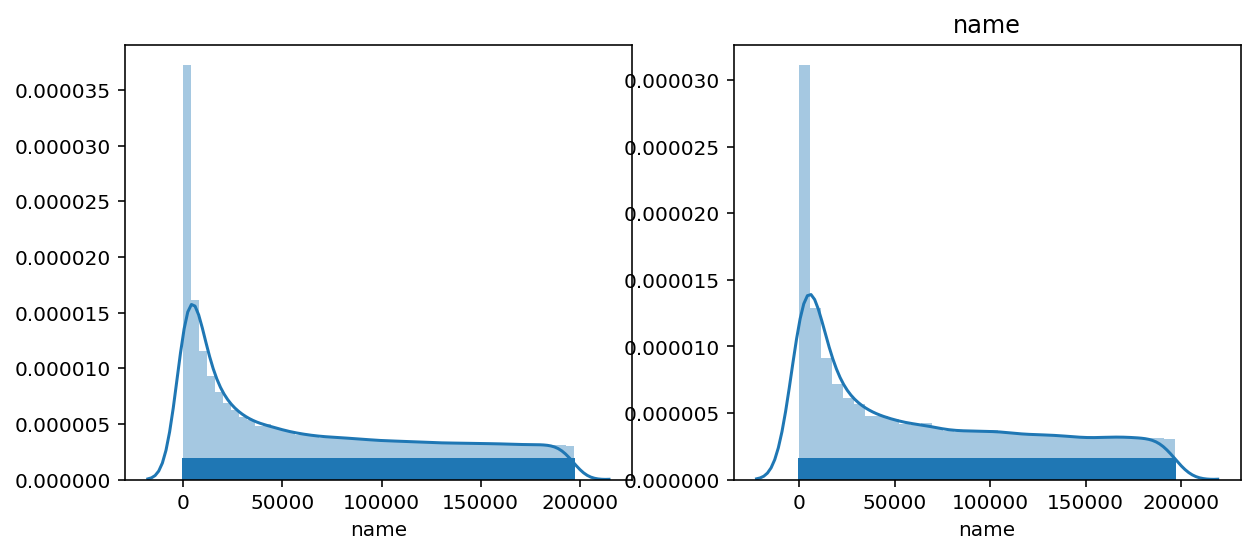

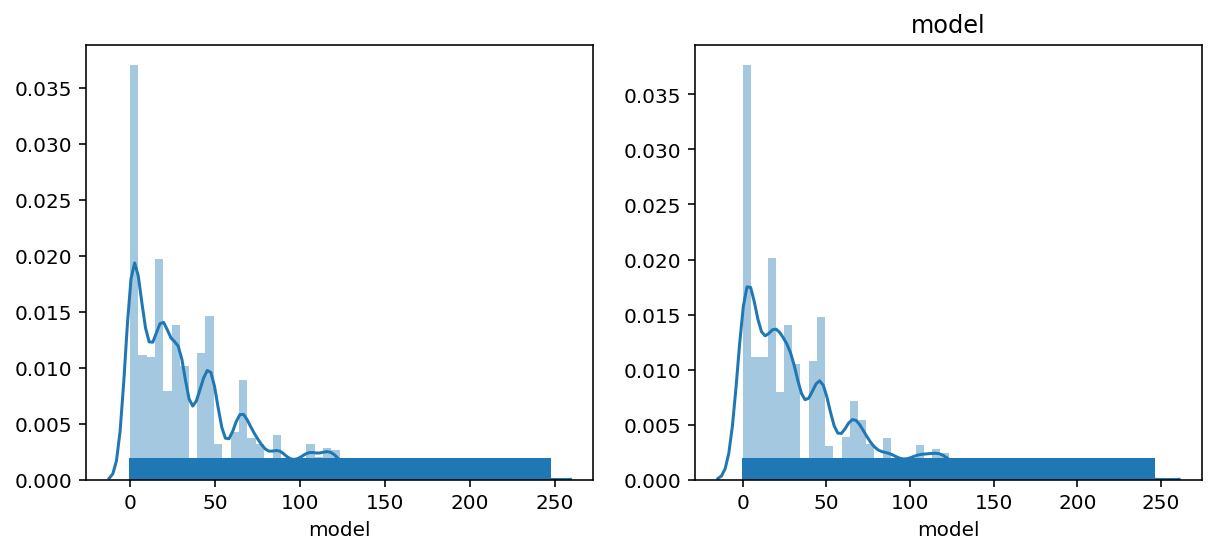

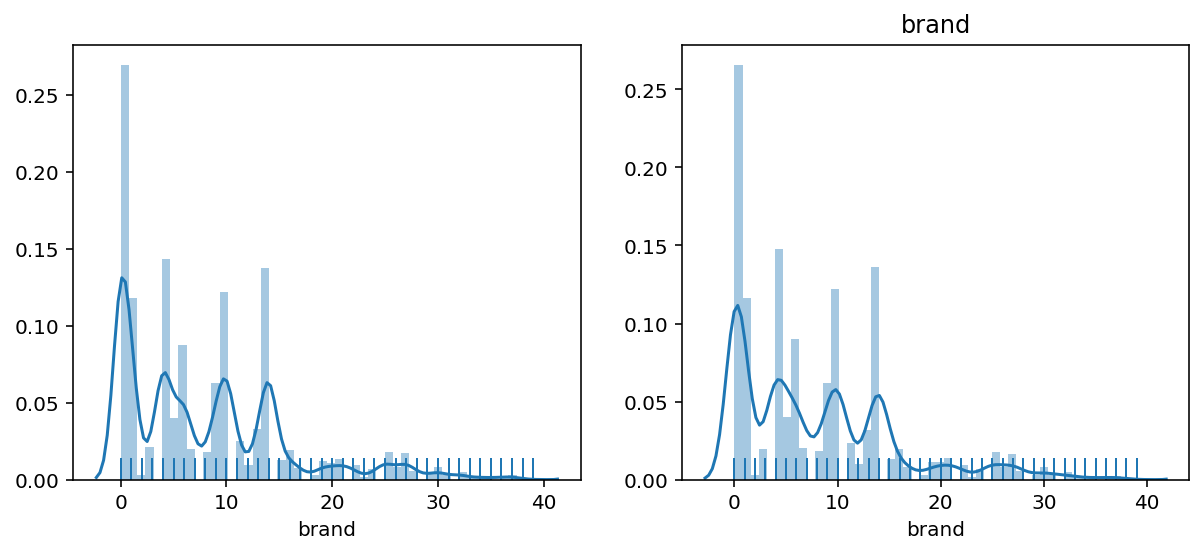

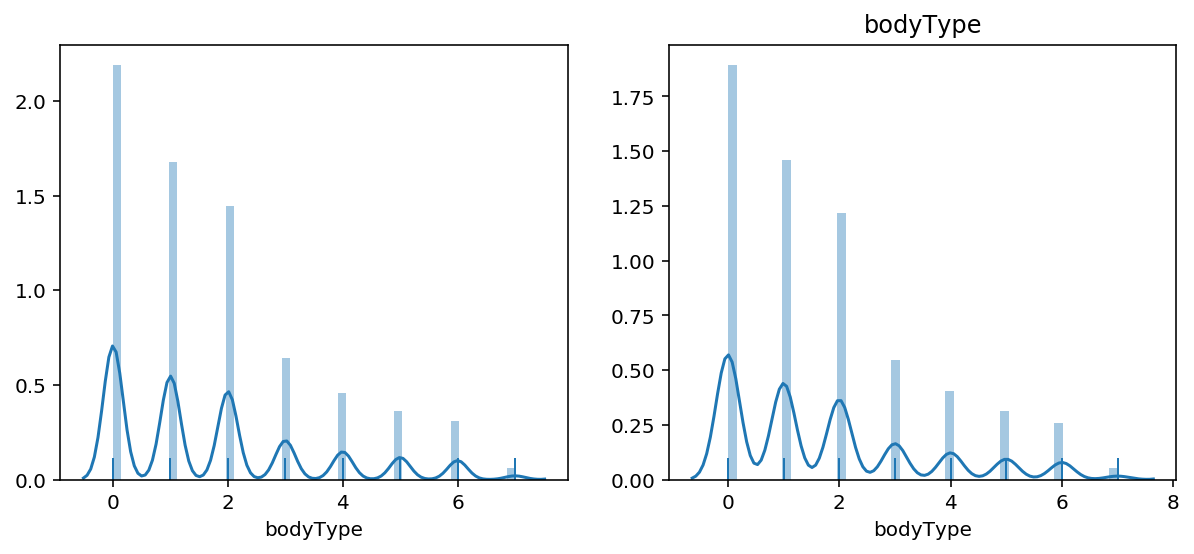

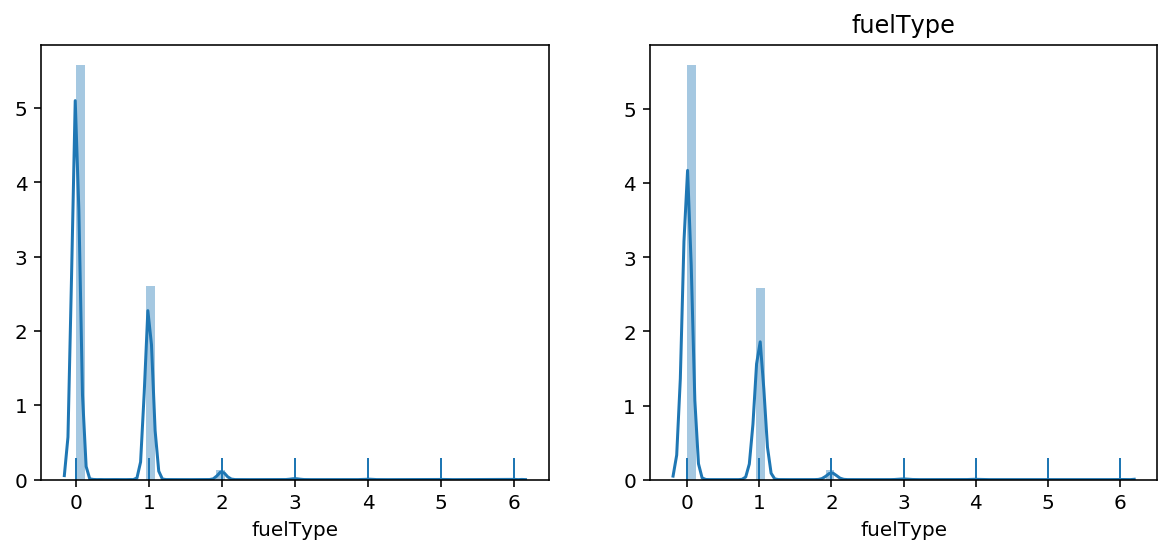

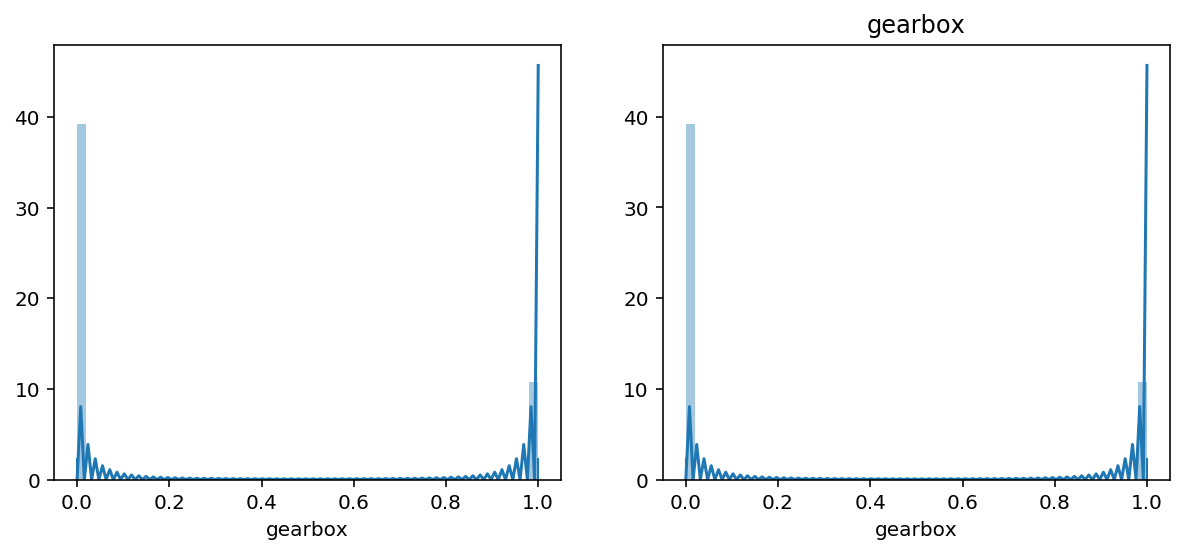

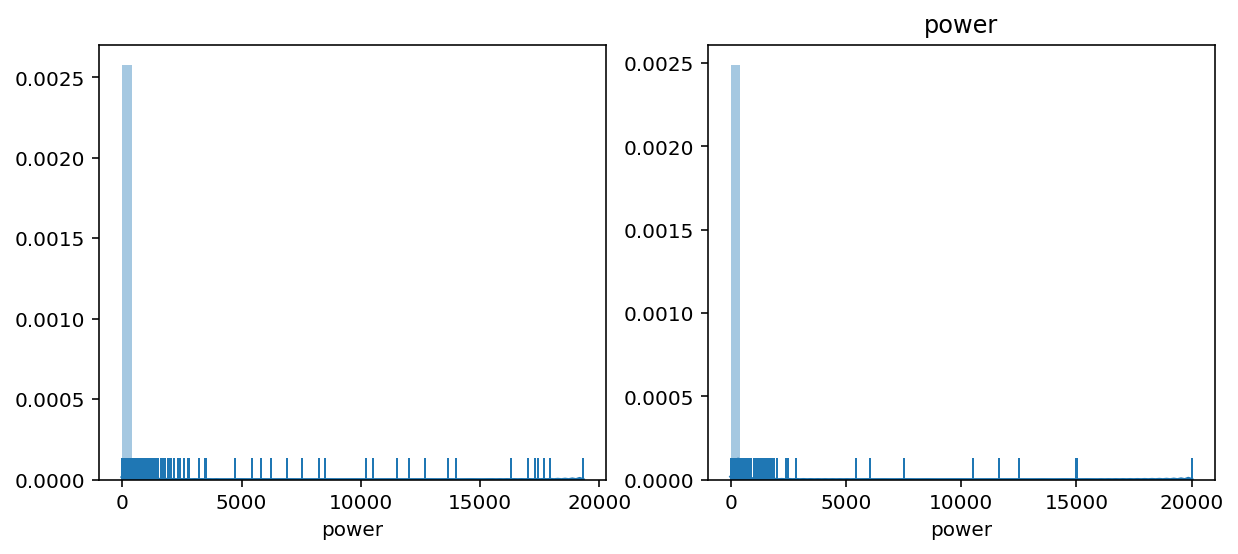

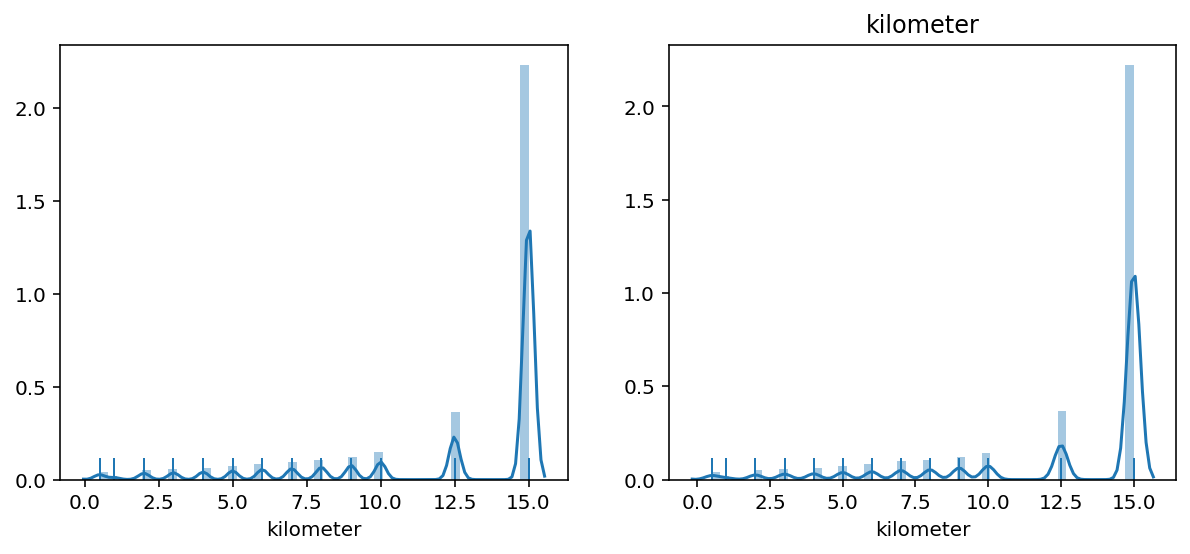

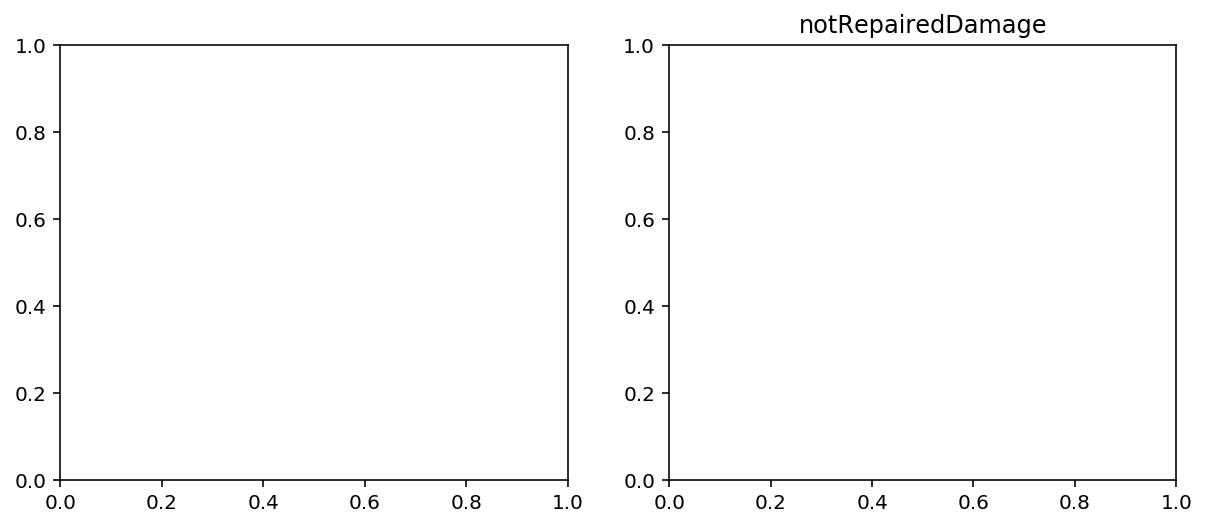

In [161]:
for index in data.columns:
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    plt.title(index)
    sns.distplot(data[index].fillna(0), rug=True, ax=ax[0])
    if index is not 'price':
        sns.distplot(data_predict[index].fillna(0), rug=True, ax=ax[1])

#     plt.title(index)
#     fig, ax = plt.subplots(1,2, figsize=(10,4))
#     data[index].plot.box(ax=ax[0])
#     if index is not 'price':
#         data_predict[index].plot.box(ax=ax[0])

/Users/apple/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


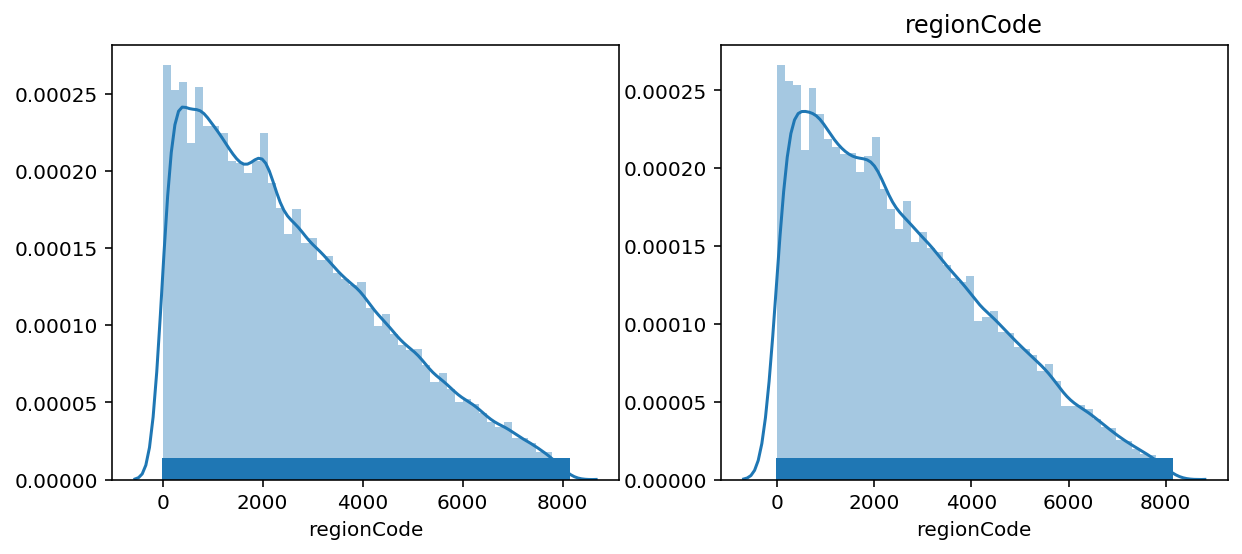

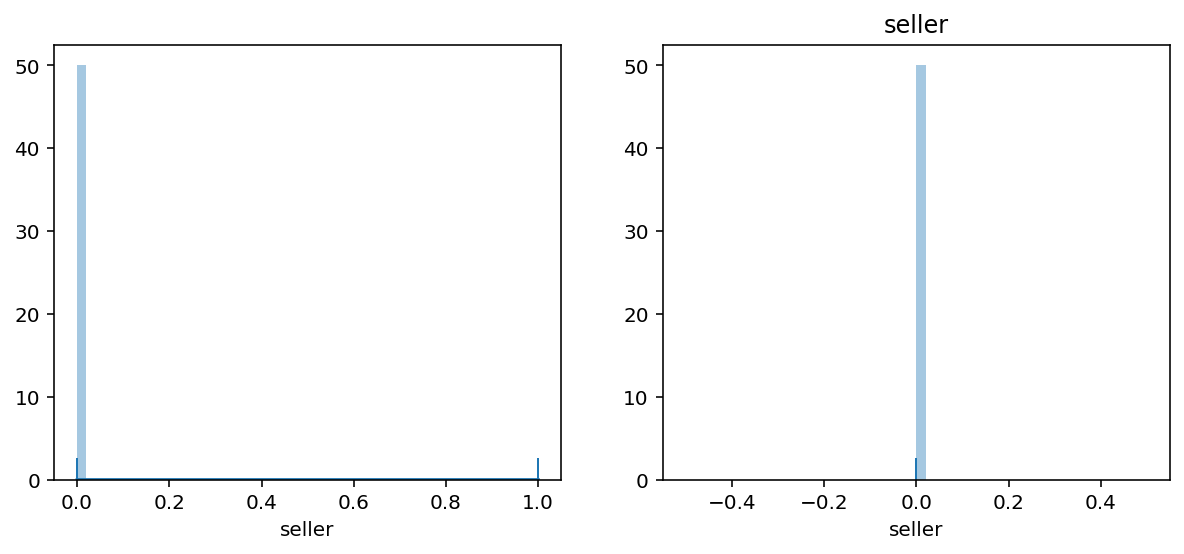

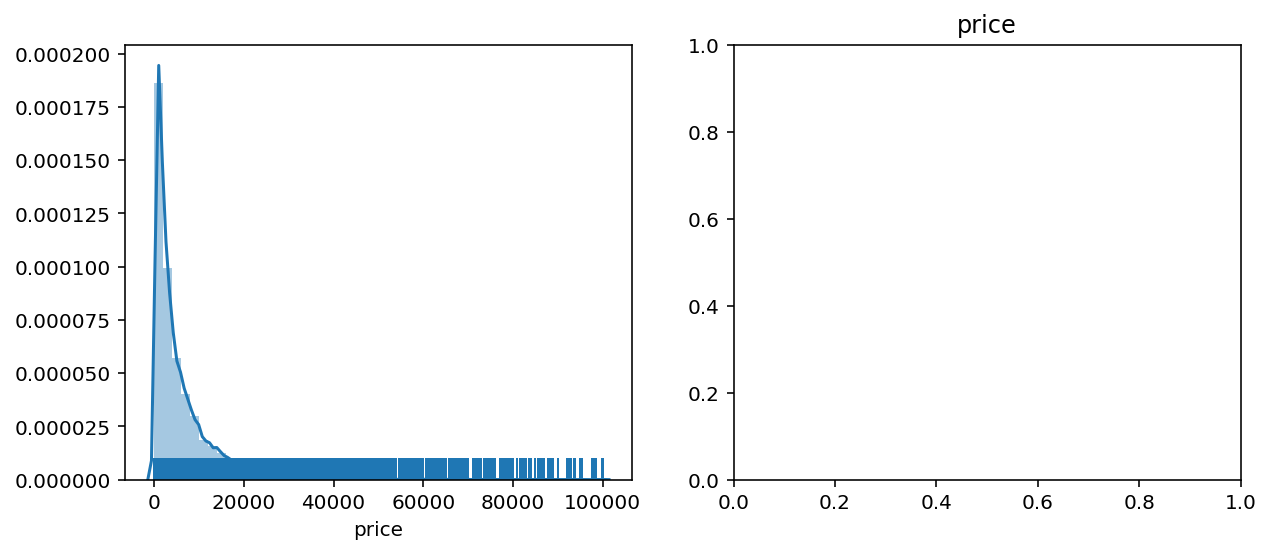

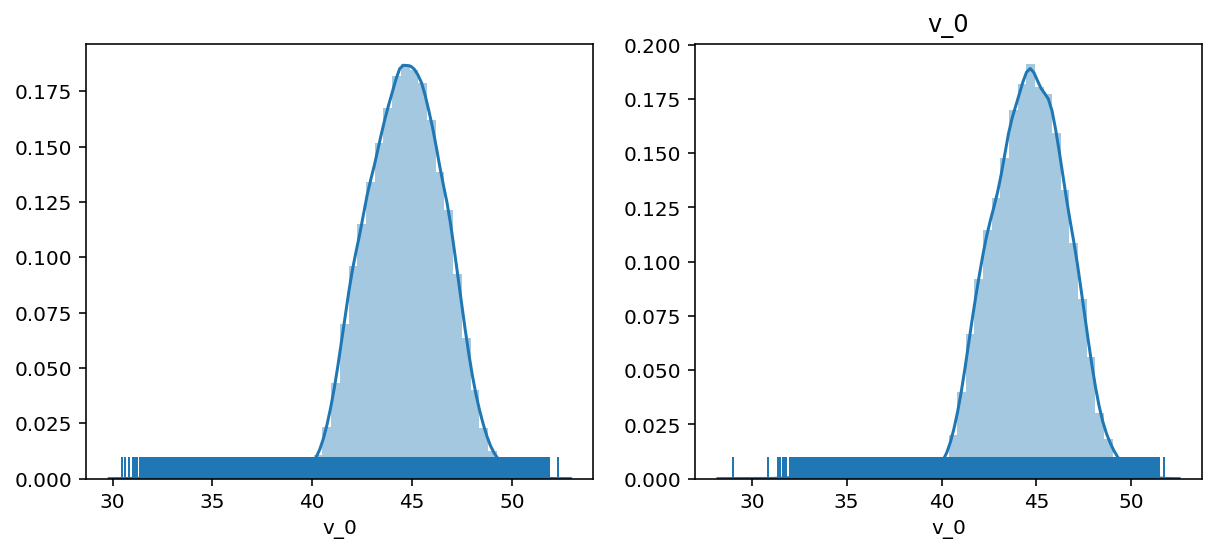

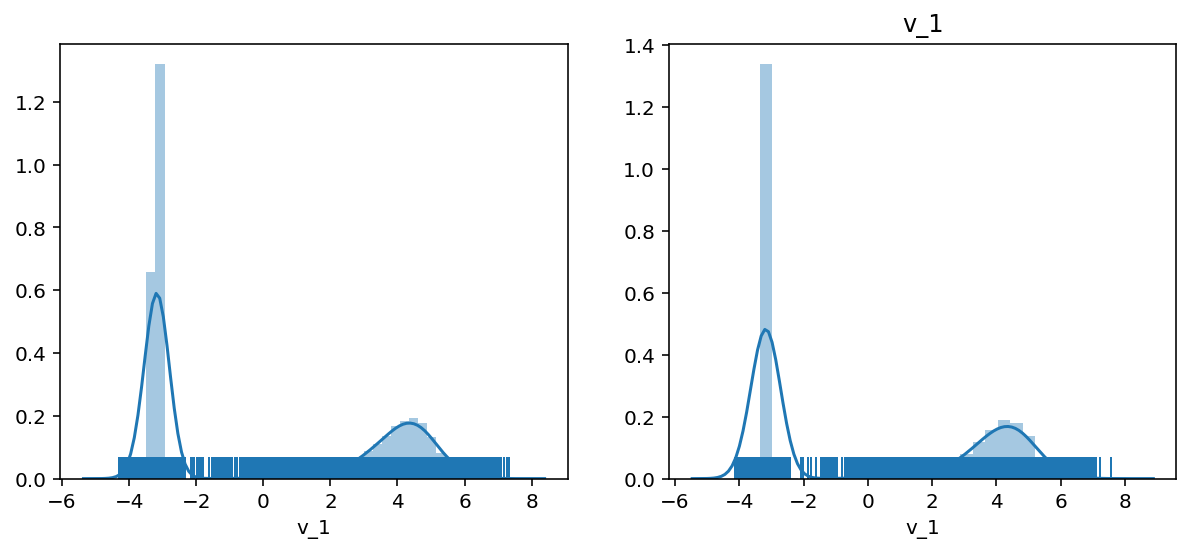

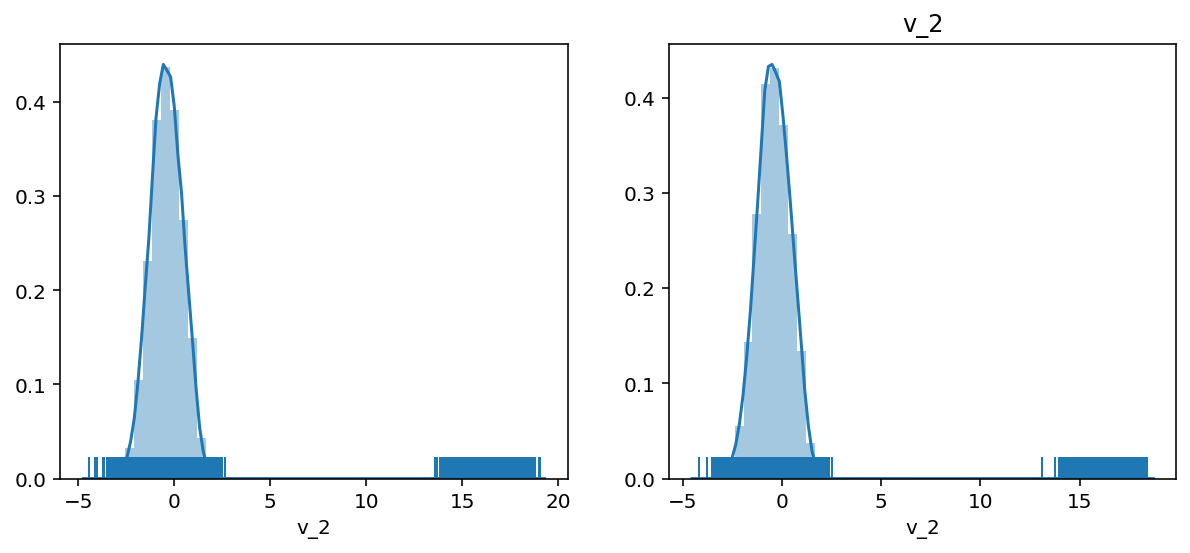

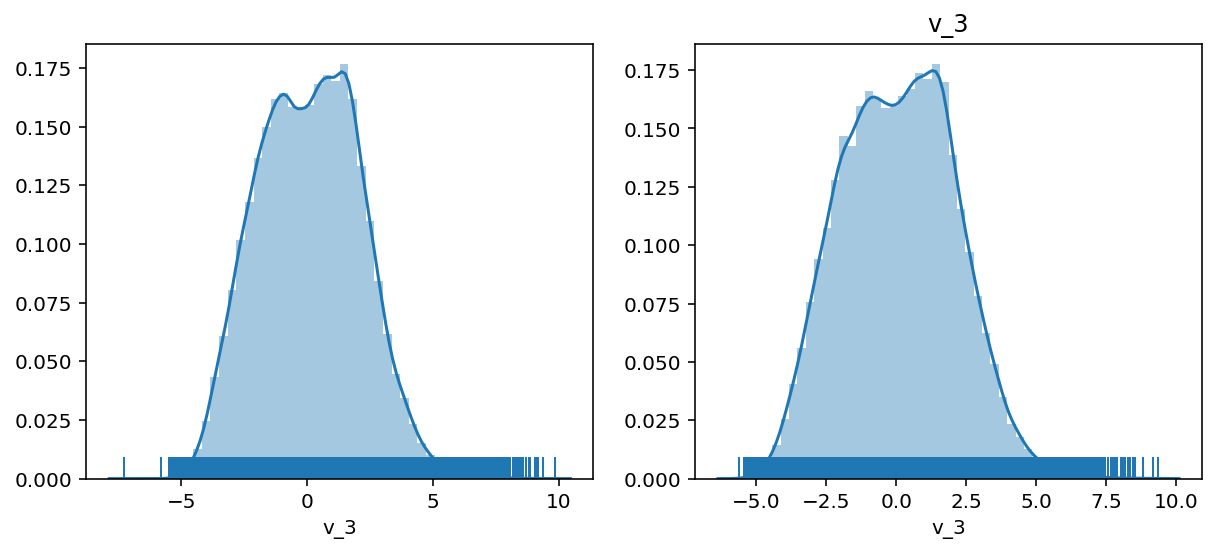

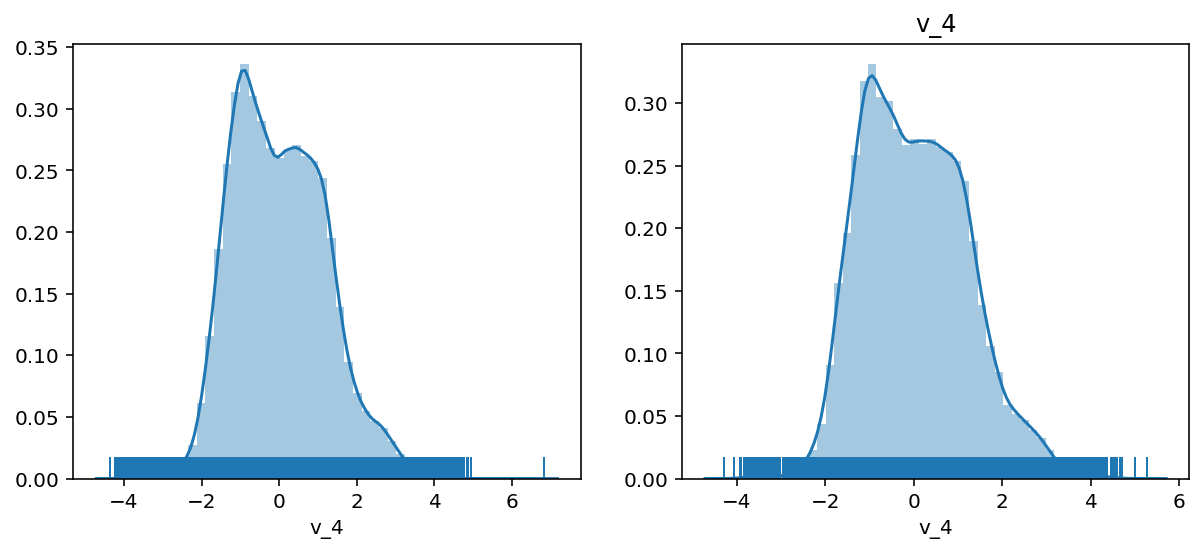

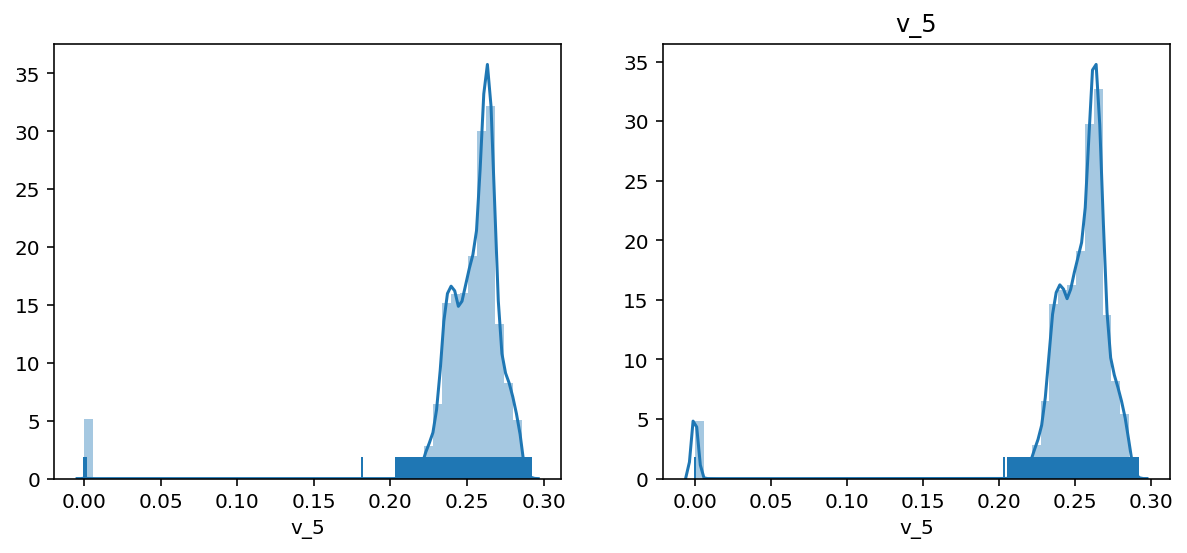

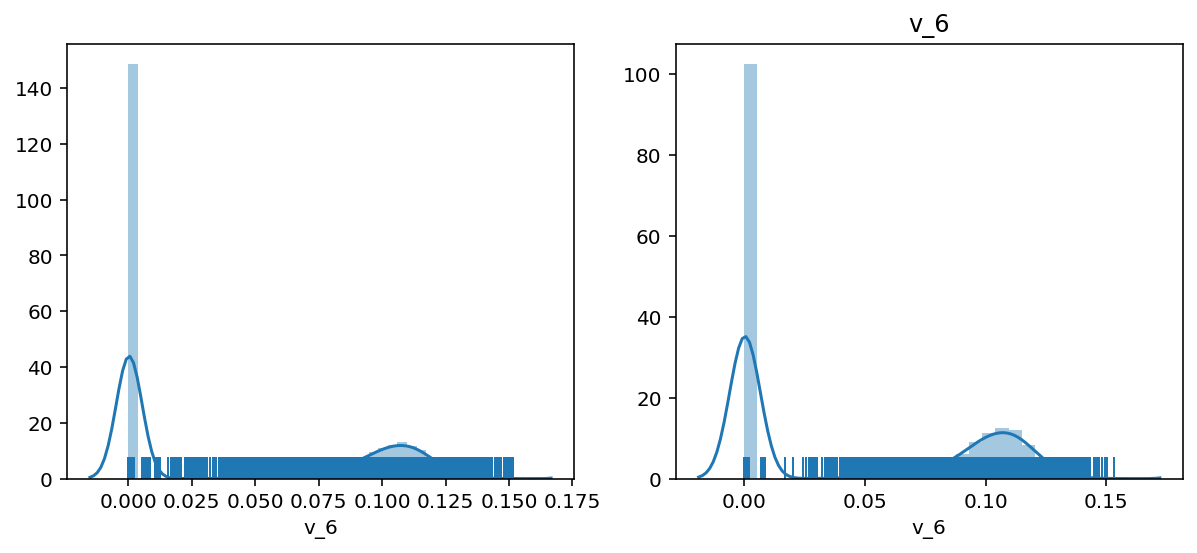

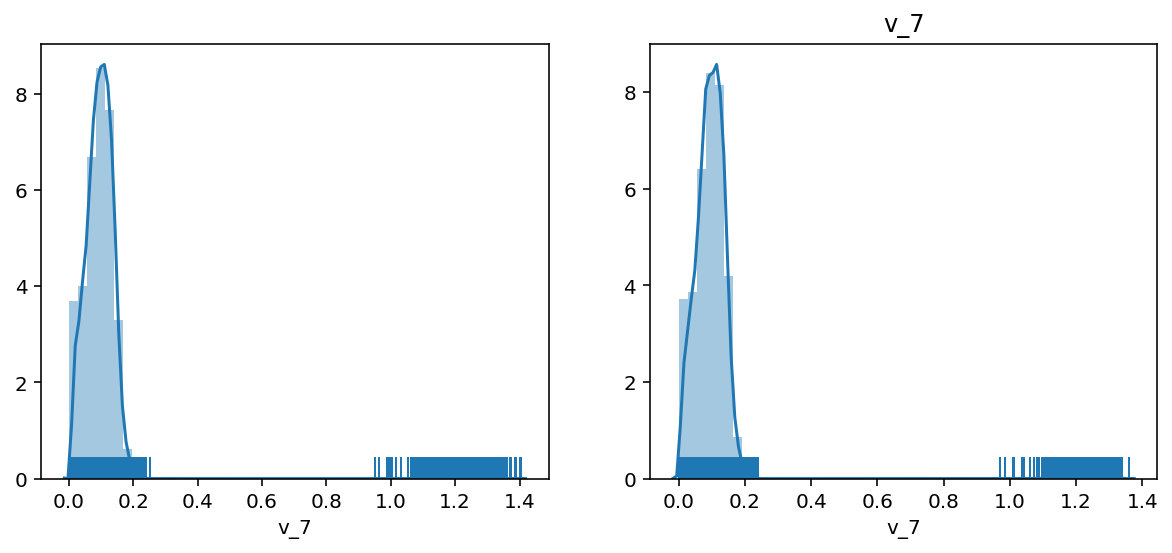

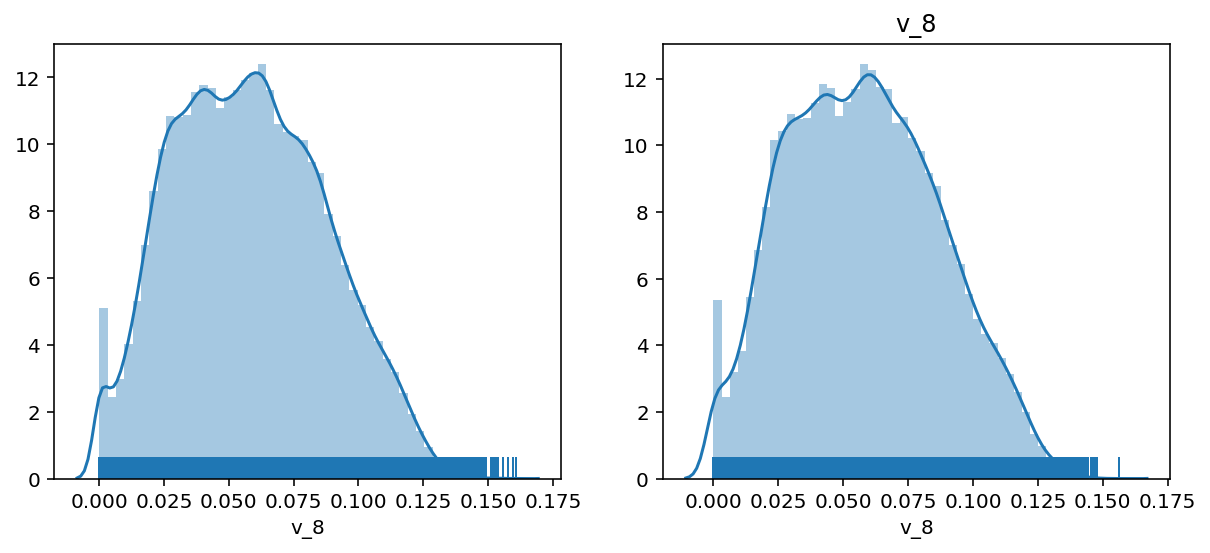

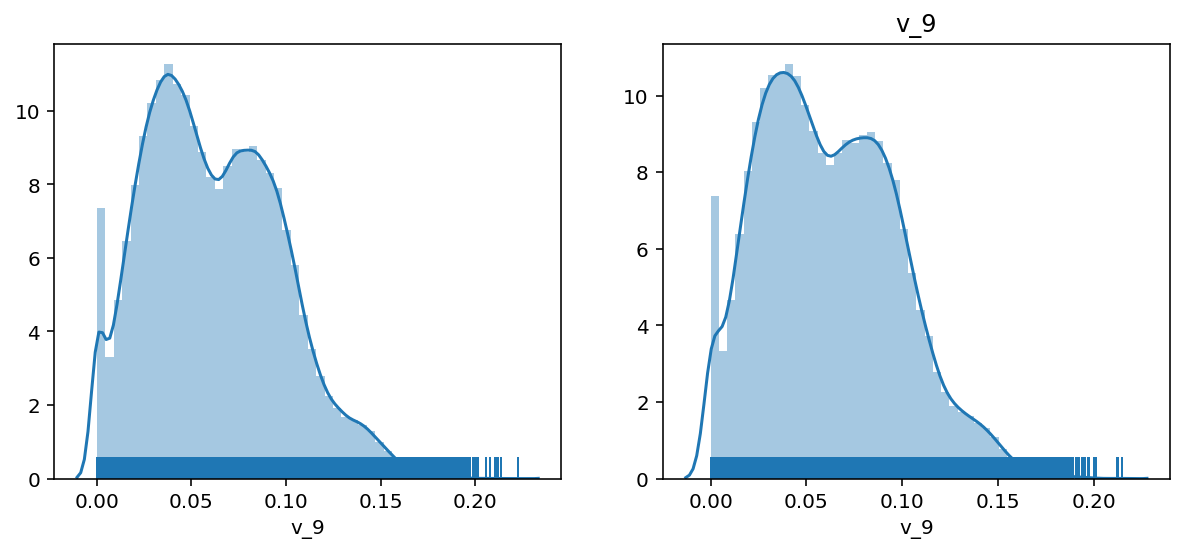

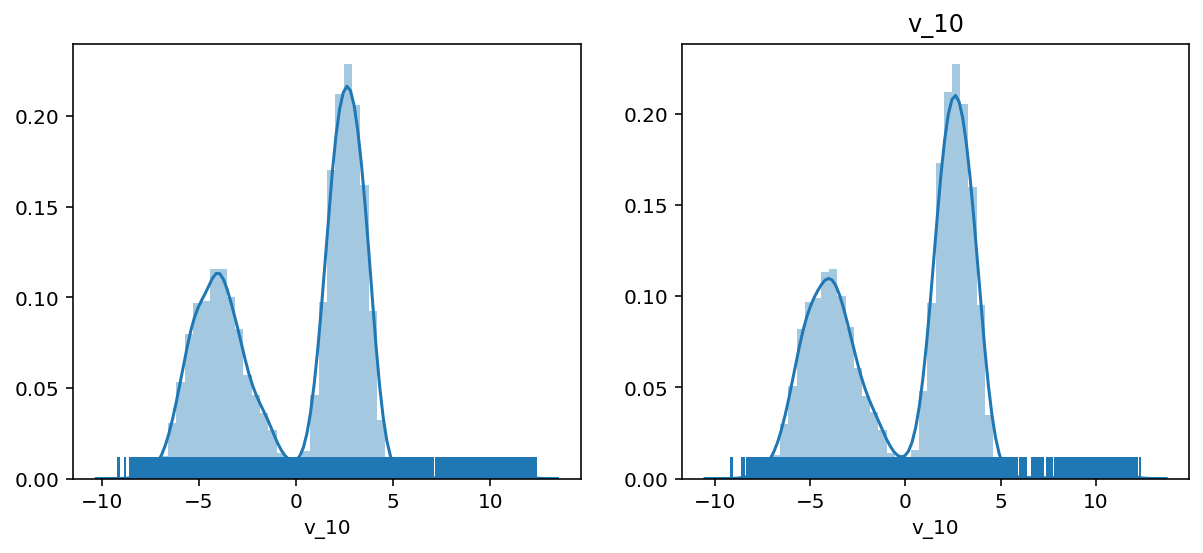

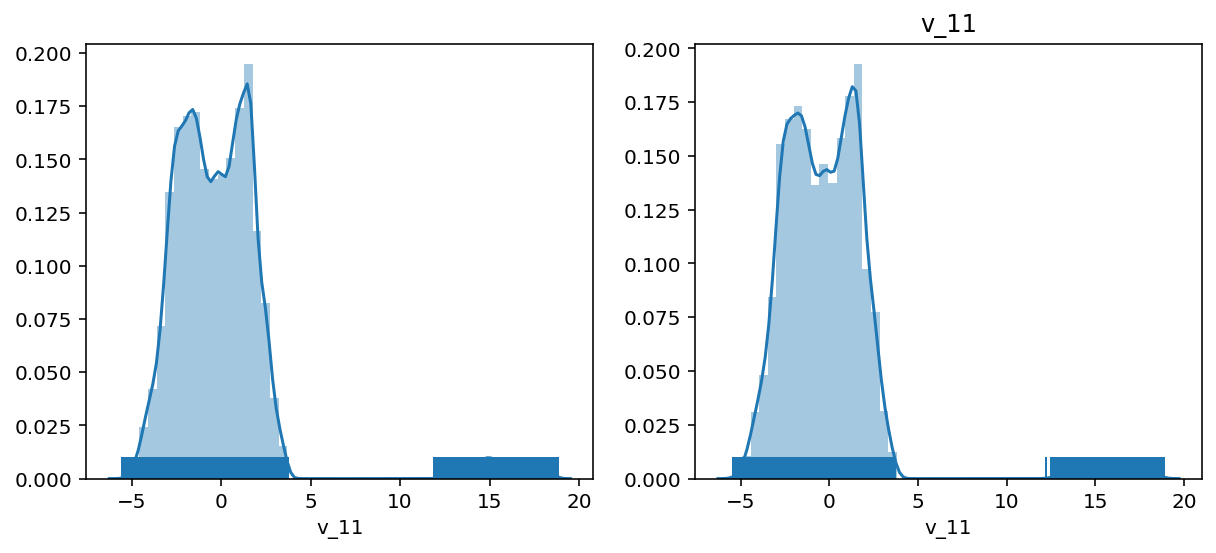

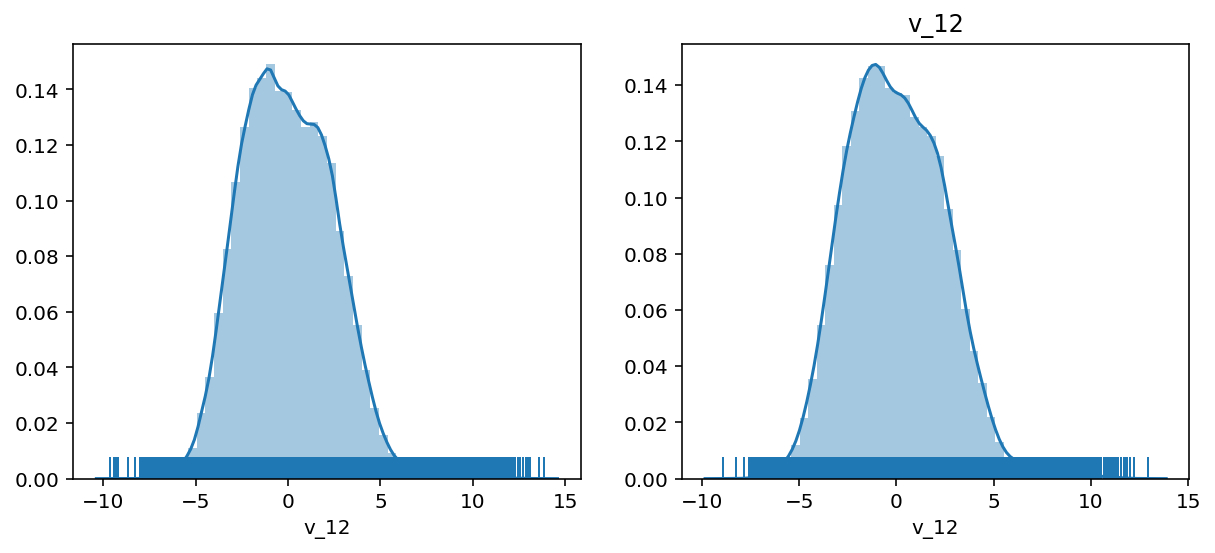

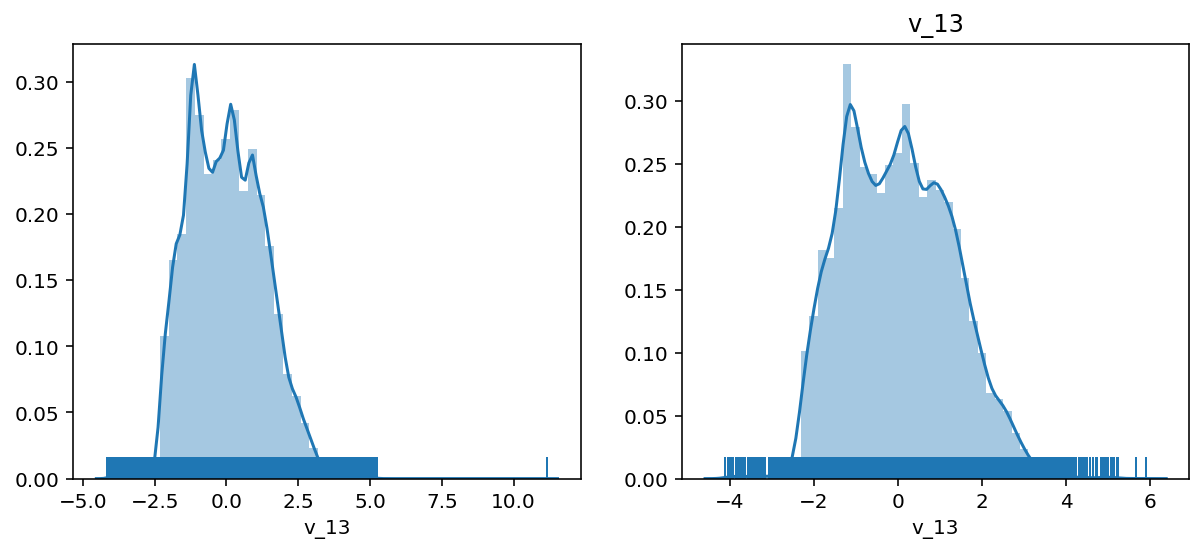

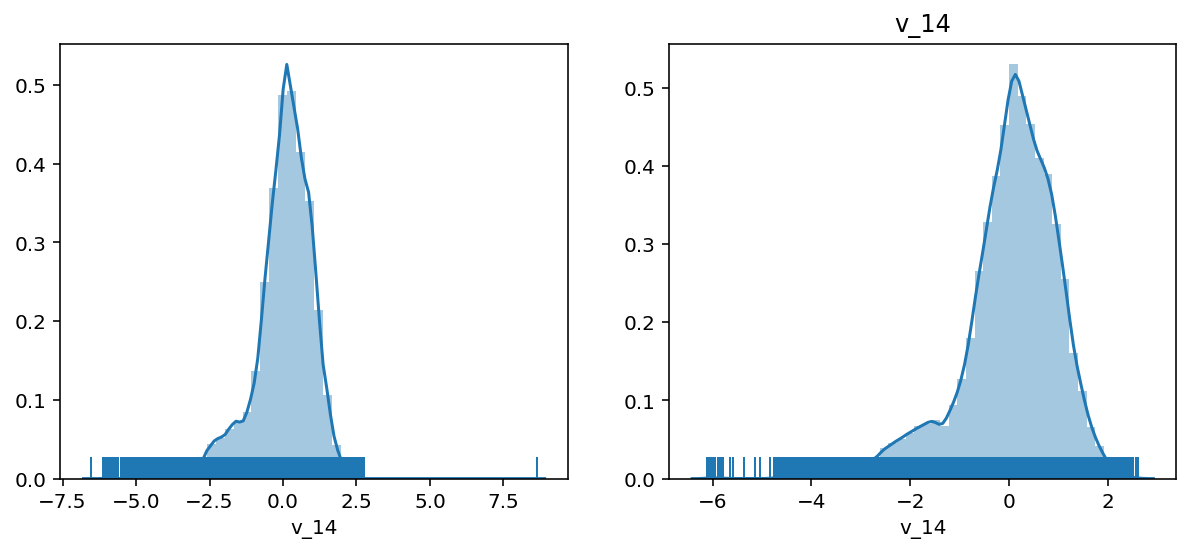

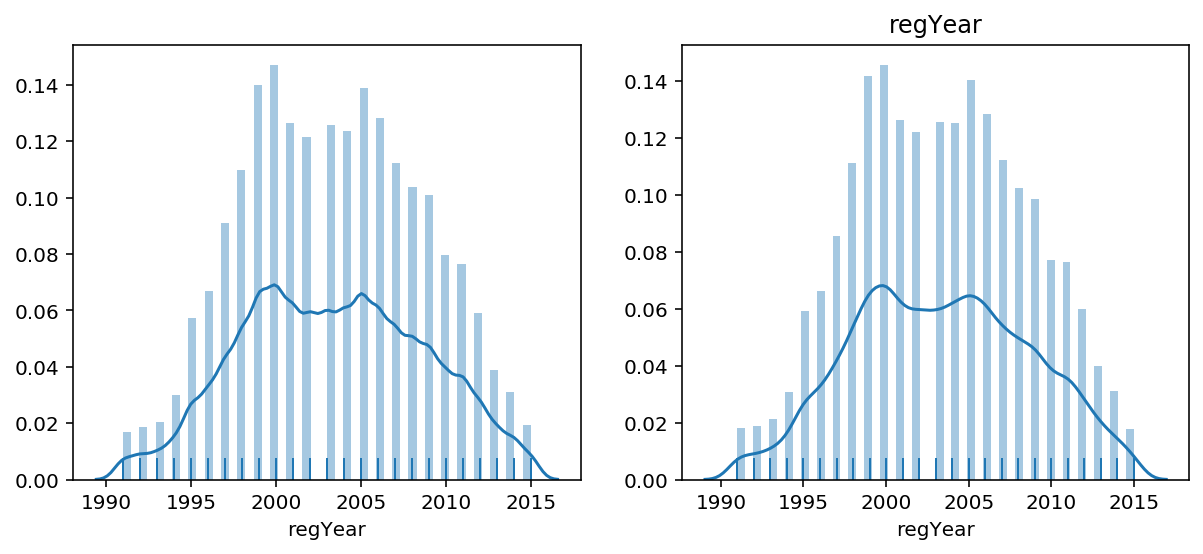

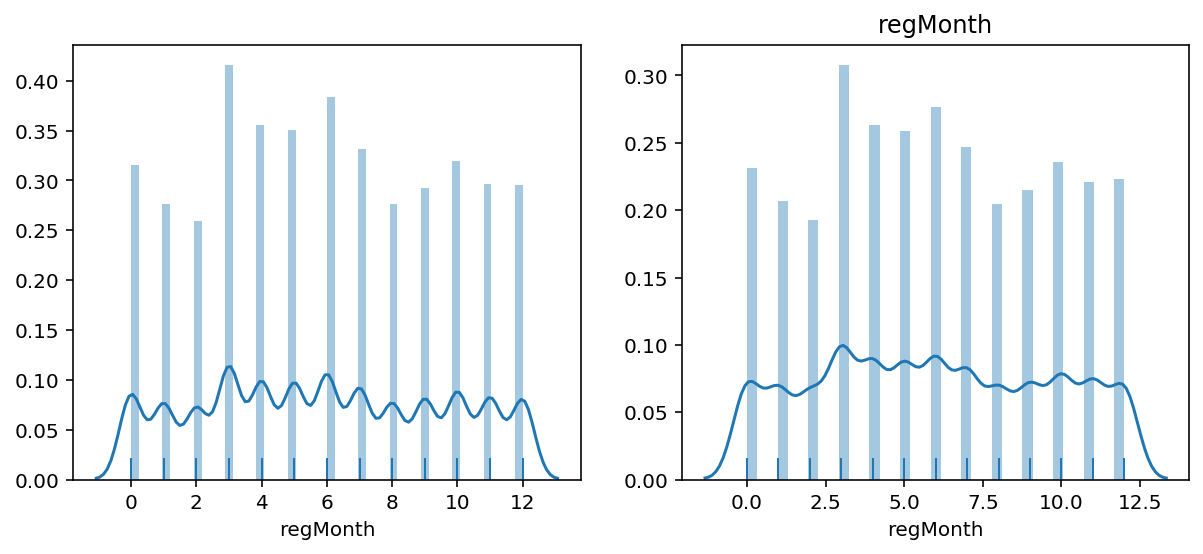

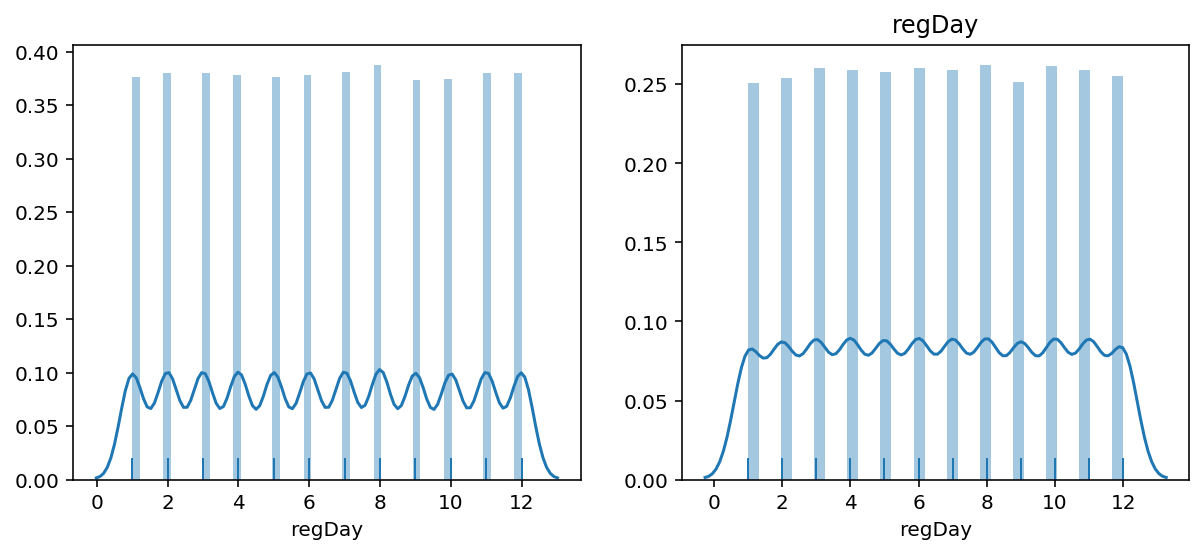

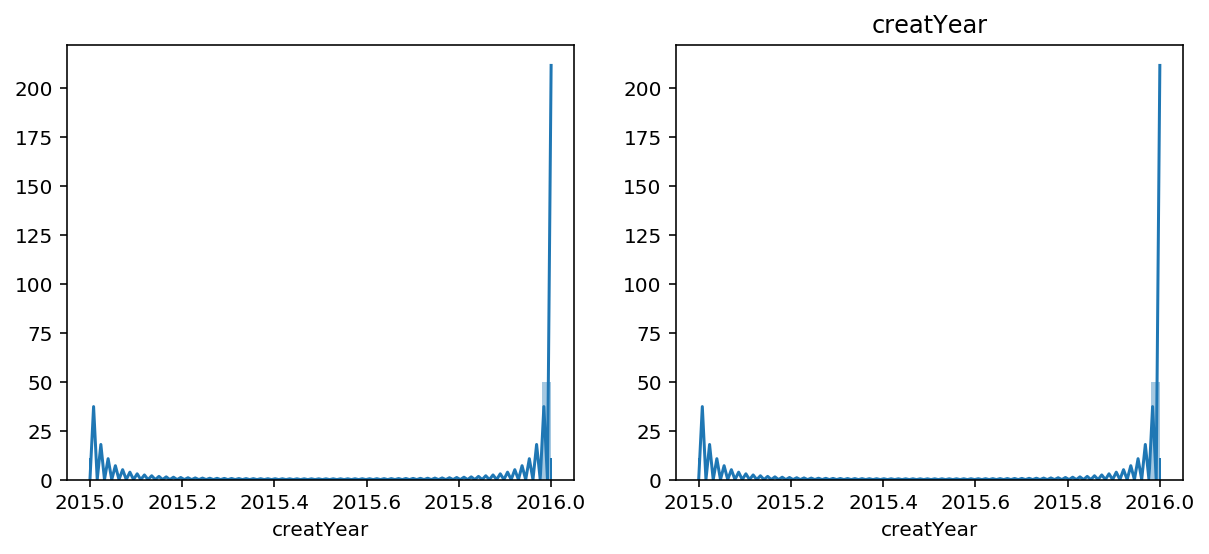

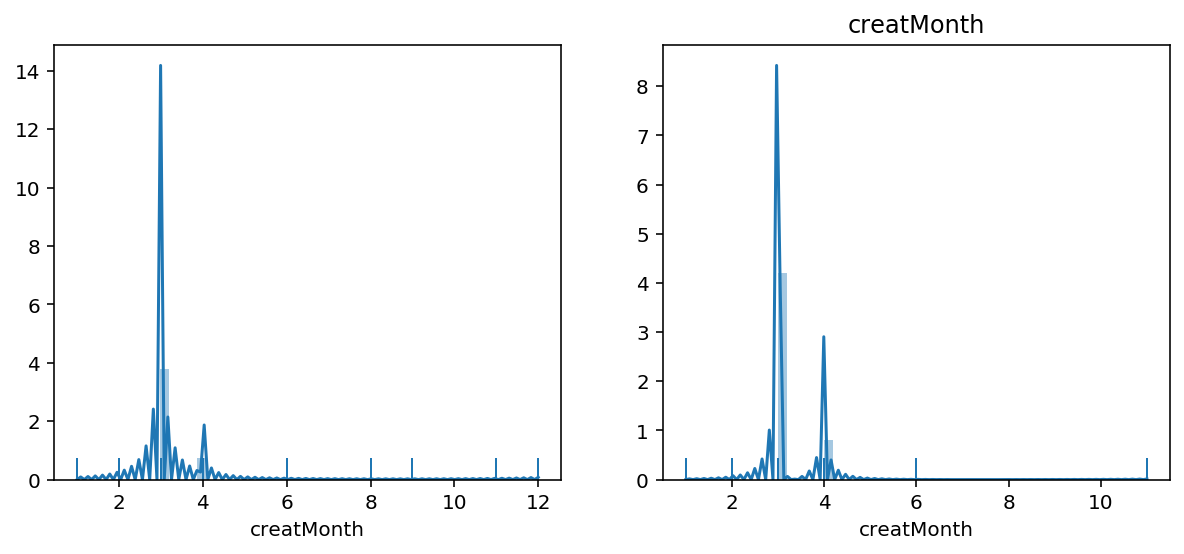

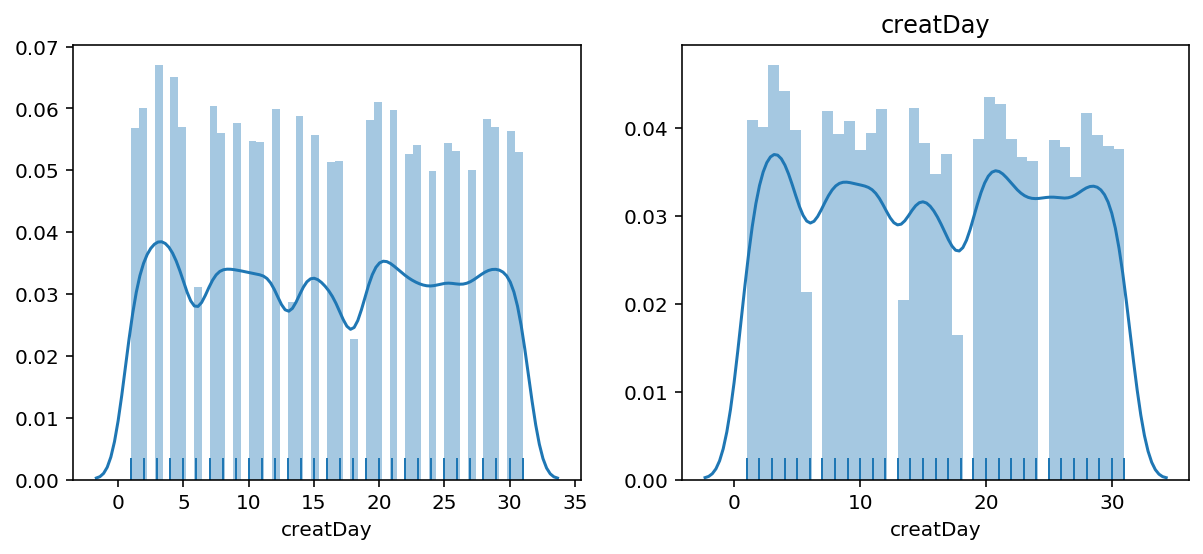

In [166]:
for index in data.columns[9:]:
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    plt.title(index)
    sns.distplot(data[index].fillna(0), rug=True, ax=ax[0])
    if index != 'price':
        sns.distplot(data_predict[index].fillna(0), rug=True, ax=ax[1])

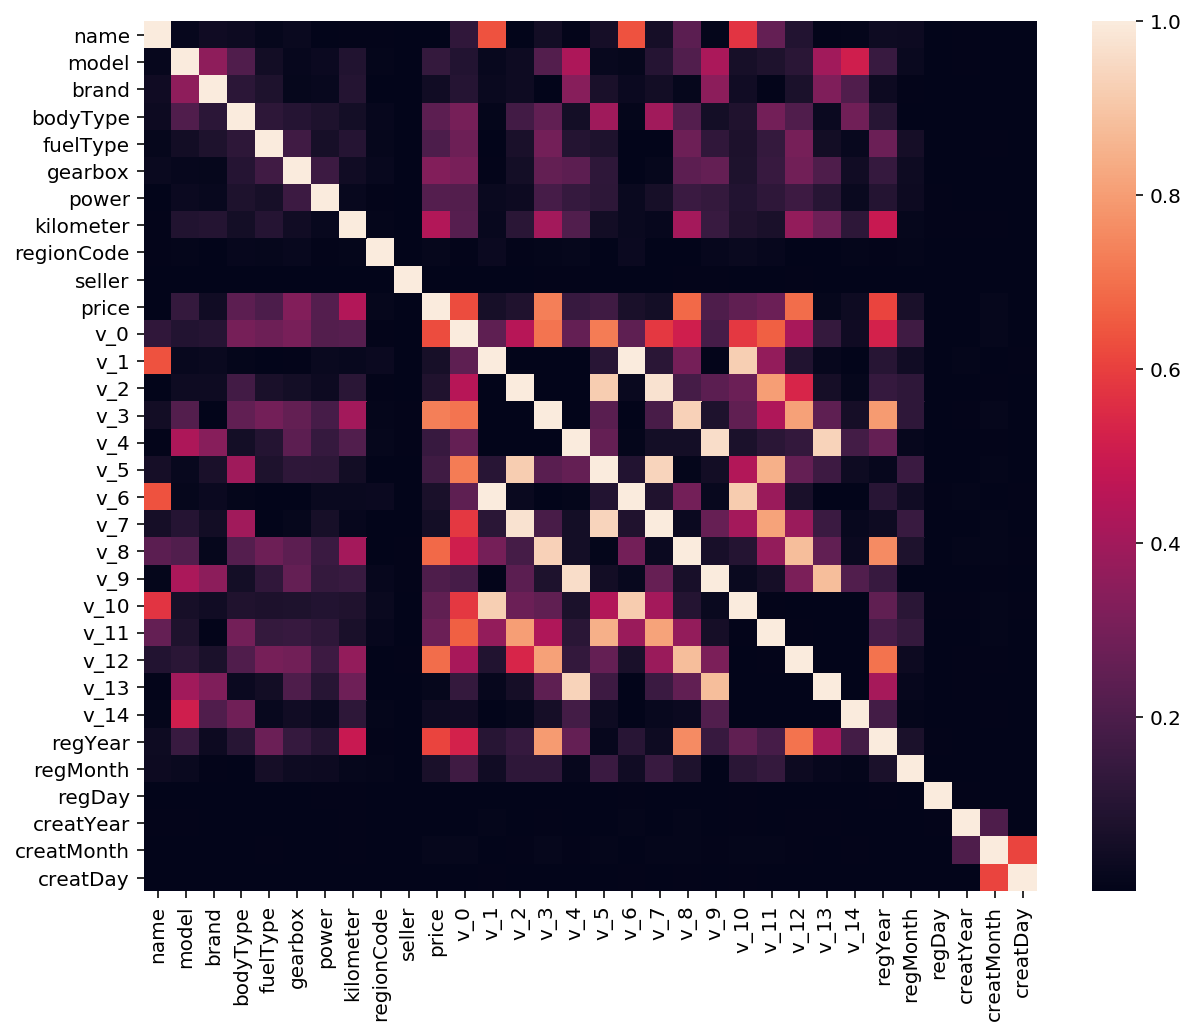

In [174]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(abs(data.corr()))

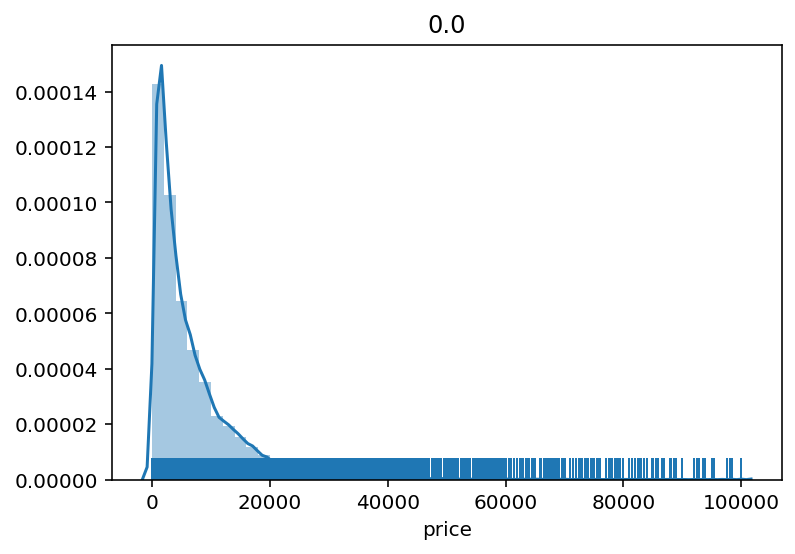

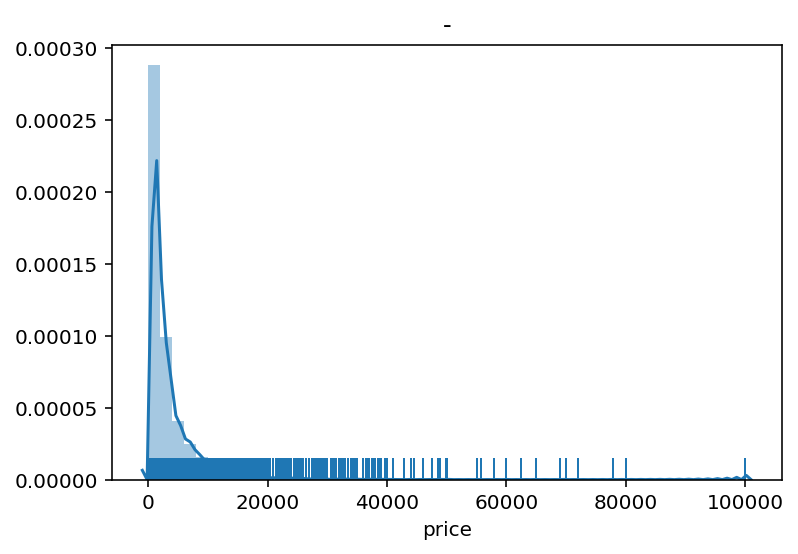

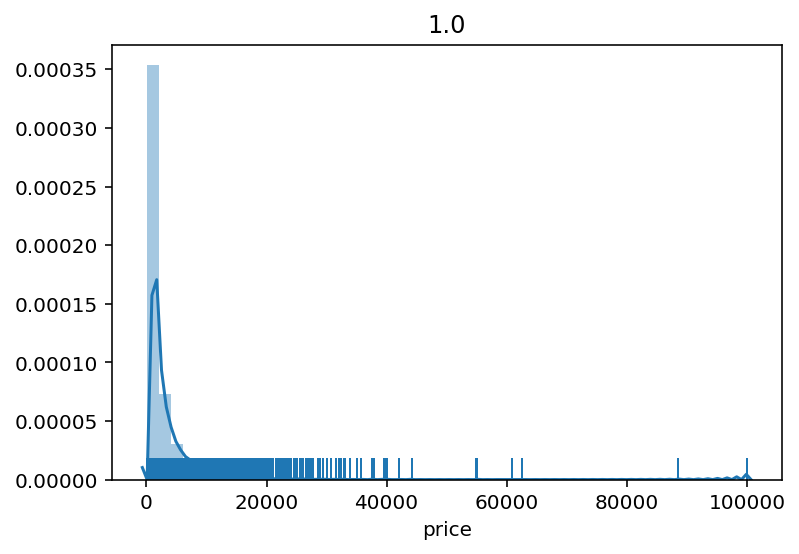

In [182]:

for a in data['notRepairedDamage'].unique():
    plt.subplots()
    plt.title(a)
    sns.distplot(data['price'][data.notRepairedDamage==a], rug=True)